In [ ]:

"""
============================================================================================
 COMPARAÇÃO DE REDUÇÃO DE DIMENSIONALIDADE: AUTOENCODER (PYTORCH) vs PCA
============================================================================================
Disciplina: IA Generativa (PPGEE0248) - Programa de Pós-Graduação em Engenharia Elétrica (UFPA)
Autor: Prof. Dr. Bruno Duarte Gomes | Data: Setembro/2025
--------------------------------------------------------------------------------------------
Este código fornece uma estrutura para os alunos estudarem a performance de autoencoders e PCA
na redução de dimensionalidade. O usuário insere seus próprios dados (matriz de características).
Permite modificar arquitetura do autoencoder, hiperparâmetros e a dimensão latente.
============================================================================================
"""

# Importações principais
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================================================
# Função para inserir os dados dos alunos (X: matriz de características)
# ============================================================================================
def load_user_data(np_array):
    """
    Função básica para carregar dados do usuário
    Args:
        np_array: numpy array (n amostras x d características)
    Returns:
        X: torch.FloatTensor pronto para uso
    """
    assert isinstance(np_array, np.ndarray), "Dados devem ser numpy.ndarray."
    return torch.FloatTensor(np_array)

# ============================================================================================
# Classe simples do Autoencoder para dados tabulares ou vetores de características
# ============================================================================================
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=None):
        """
        input_dim: dimensão dos dados
        latent_dim: dimensão desejada do espaço latente
        hidden_dim: dimensão da camada oculta opcional
        """
        super().__init__()
        if hidden_dim is None:
            hidden_dim = max(latent_dim * 2, input_dim // 2)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# ============================================================================================
# Função de treinamento do autoencoder
# ============================================================================================
def train_autoencoder(X, latent_dim, num_epochs=100, batch_size=32, lr=1e-3, verbose=True):
    input_dim = X.shape[1]
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = SimpleAutoencoder(input_dim, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    losses = []
    for epoch in range(num_epochs):
        loss_epoch = 0
        for (batch,) in loader:
            optimizer.zero_grad()
            x_hat, _ = model(batch)
            loss = criterion(x_hat, batch)
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
        avg_loss = loss_epoch / len(loader)
        losses.append(avg_loss)
        if verbose and epoch % 10 == 0:
            print(f'Época {epoch}: loss = {avg_loss:.6f}')
    return model, losses

# ============================================================================================
# Função para extrair representações latentes do autoencoder
# ============================================================================================
def get_latent_representations(model, X):
    model.eval()
    with torch.no_grad():
        _, Z = model(X)
        return Z.numpy()

# ============================================================================================
# Função para PCA
# ============================================================================================
def apply_pca(X_np, latent_dim):
    pca = PCA(n_components=latent_dim)
    Z = pca.fit_transform(X_np)
    X_hat = pca.inverse_transform(Z)
    return Z, X_hat, pca

# ============================================================================================
# Função de avaliação: compara reconstrução do autoencoder e do PCA
# ============================================================================================
def evaluate_reconstruction(X_np, X_hat_ae, X_hat_pca):
    mse_ae = mean_squared_error(X_np, X_hat_ae)
    mse_pca = mean_squared_error(X_np, X_hat_pca)
    print(f"MSE Autoencoder: {mse_ae:.6f}, MSE PCA: {mse_pca:.6f}")
    return mse_ae, mse_pca

# ============================================================================================
# Função de plot simples para visualizar curva de loss
# ============================================================================================
def plot_loss_curve(losses):
    plt.figure(figsize=(8,5))
    plt.plot(losses, 'o-', label='Train loss (MSE)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Curva de aprendizado do Autoencoder')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# ============================================================================================
# Exemplo mínimo de uso para que o aluno modifique conforme necessário
# ============================================================================================
if __name__ == "__main__":
    # Carregue seus próprios dados como numpy array: X_raw (n_amostras x n_features)
    # Exemplo: X_raw = np.random.rand(500, 20)
    #X_raw = np.random.rand(500, 20)  # SUBSTITUA por seus próprios dados
    #Definindo a localização do dataset
    url = "https://raw.githubusercontent.com/ThiagoFigueiroRibeiro/AIGen_DisciplinaPPGEE/main/autoencoder_1/autoencoder_1_ThiagoFigueiro_Dataset.csv"

    # Lendo o dataset da URLA dada
    df = pd.read_csv(url)

    # Separando features (X_raw) e labels (y)
    X_raw = df.drop(columns=["label"]).values
    y = df["label"].values

    # Pré-processamento sugerido
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_np = scaler.fit_transform(X_raw)
    X = load_user_data(X_np)  # convertendo para tensor

    # Defina a dimensão latente desejada
    latent_dim = 10
    # Treine o autoencoder
    mse_ae = np.zeros(latent_dim+1)
    mse_pca = np.zeros(latent_dim+1)
    print("Treinando autoencoder...")
    for dimensions in range(0, latent_dim+1, 1):
      print("Latent dimensions: " + str(dimensions))
      model, losses = train_autoencoder(X, dimensions, num_epochs = 100, batch_size=32, lr=1e-3, verbose=False)
      # Obtenha reconstruções
      model.eval()
      with torch.no_grad():
          X_hat_ae, Z_ae = model(X)
          X_hat_ae = X_hat_ae.numpy()
          Z_ae = Z_ae.numpy()


      # PCA para mesma dimensão
      #print("Aplicando PCA...")
      Z_pca, X_hat_pca, pca_model = apply_pca(X_np, dimensions)

      # Avaliação das reconstruções
      #print("Comparando reconstrução do Autoencoder e PCA:")
      mse_ae[dimensions], mse_pca[dimensions] = evaluate_reconstruction(X_np, X_hat_ae, X_hat_pca)
    print("Treino terminado!")

Treinando autoencoder...
Latent dimensions: 0


/usr/local/lib/python3.12/dist-packages/torch/nn/init.py:582: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


MSE Autoencoder: 0.041649, MSE PCA: 0.041648
Latent dimensions: 1
MSE Autoencoder: 0.024051, MSE PCA: 0.033740
Latent dimensions: 2
MSE Autoencoder: 0.021369, MSE PCA: 0.026656
Latent dimensions: 3
MSE Autoencoder: 0.011271, MSE PCA: 0.020500
Latent dimensions: 4
MSE Autoencoder: 0.008307, MSE PCA: 0.015297
Latent dimensions: 5
MSE Autoencoder: 0.006302, MSE PCA: 0.010617
Latent dimensions: 6
MSE Autoencoder: 0.005918, MSE PCA: 0.007121
Latent dimensions: 7
MSE Autoencoder: 0.005791, MSE PCA: 0.004978
Latent dimensions: 8
MSE Autoencoder: 0.005269, MSE PCA: 0.004590
Latent dimensions: 9
MSE Autoencoder: 0.005209, MSE PCA: 0.004227
Latent dimensions: 10
MSE Autoencoder: 0.004701, MSE PCA: 0.003896
Treino terminado!


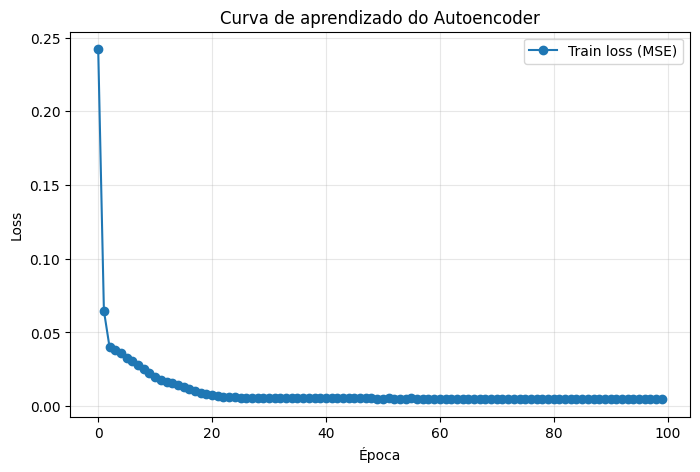

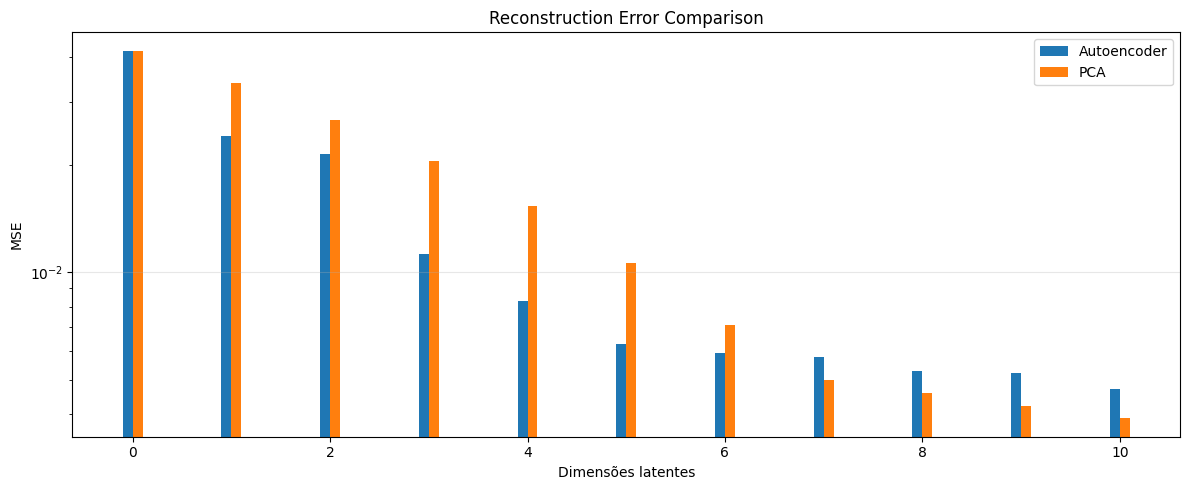

CÓDIGO DESENVOLVIDO POR: Prof. Dr. Bruno Duarte Gomes
DISCIPLINA: IA Generativa (PPGEE0248)
Programa de Pós-Graduação em Engenharia Elétrica (UFPA)


In [ ]:
plot_loss_curve(losses)

epochs = np.arange(len(mse_ae))  # x positions

bar_width = 0.1
plt.figure(figsize=(12,5))

plt.bar(epochs - bar_width/2, mse_ae, width=bar_width, label="Autoencoder")
plt.bar(epochs + bar_width/2, mse_pca, width=bar_width, label="PCA")

plt.xlabel("Dimensões latentes")
plt.ylabel("MSE")
plt.yscale("log")  # keep log scale for comparison
plt.title("Reconstruction Error Comparison")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
# Visualização opcional do espaço latente 2D (caso latent_dim=2)
if latent_dim == 2:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(Z_ae[:,0], Z_ae[:,1], alpha=0.7)
    plt.title('Espaço Latente - Autoencoder')
    plt.grid(True, alpha=0.3)
    plt.subplot(1,2,2)
    plt.scatter(Z_pca[:,0], Z_pca[:,1], alpha=0.7)
    plt.title('Espaço Latente - PCA')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("=====================================================")
print("CÓDIGO DESENVOLVIDO POR: Prof. Dr. Bruno Duarte Gomes")
print("DISCIPLINA: IA Generativa (PPGEE0248)")
print("Programa de Pós-Graduação em Engenharia Elétrica (UFPA)")
print("=====================================================")